In [2]:
import gc
import os
import time
from tqdm.notebook import tqdm
import numpy as np
import talib
from talib import MA_Type
import pandas as pd
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [4]:
path_price = r'D:\code\stock\usa\price\price'
list_file_price = [os.path.join(path_price, filename) for filename in os.listdir(path_price) if os.path.isfile(os.path.join(path_price, filename))]

In [5]:
df = None
filter_start_time = '2010-01-01'
select_col = ['Date', 'symbol', 
              'Open', 'High', 'Low', 'Close', 
              'Adj Close', 'Volume', 
              'Dividends', 'Stock Splits', 'sector', 'country', 'exchange']

for file in tqdm(list_file_price):
    # print(file)
    df_price = pd.read_csv(file)[select_col]
    df_price = df_price[df_price['Date'] >= filter_start_time]
    
    if df is None:
        df = df_price.copy()
    else:
        df = pd.concat([df, df_price], axis=0)
    
    del df_price
    gc.collect()

In [6]:
df.dropna(inplace=True)
df.shape

(815711, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815711 entries, 2545 to 8419
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          815711 non-null  object 
 1   symbol        815711 non-null  object 
 2   Open          815711 non-null  float64
 3   High          815711 non-null  float64
 4   Low           815711 non-null  float64
 5   Close         815711 non-null  float64
 6   Adj Close     815711 non-null  float64
 7   Volume        815711 non-null  float64
 8   Dividends     815711 non-null  float64
 9   Stock Splits  815711 non-null  float64
 10  sector        815711 non-null  object 
 11  country       815711 non-null  object 
 12  exchange      815711 non-null  object 
dtypes: float64(8), object(5)
memory usage: 87.1+ MB


In [8]:
df.isna().sum()

Date            0
symbol          0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
sector          0
country         0
exchange        0
dtype: int64

In [9]:
df.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange
2545,2010-01-04,A,22.453505,22.625179,22.267525,22.389128,20.487326,3815500.0,0.0,0.0,Healthcare,United States,NYQ
2546,2010-01-05,A,22.324749,22.331903,22.002861,22.145924,20.264772,4186000.0,0.0,0.0,Healthcare,United States,NYQ
2547,2010-01-06,A,22.067240,22.174536,22.002861,22.067240,20.192778,3243700.0,0.0,0.0,Healthcare,United States,NYQ
2548,2010-01-07,A,22.017168,22.045780,21.816881,22.038626,20.166594,3095100.0,0.0,0.0,Healthcare,United States,NYQ
2549,2010-01-08,A,21.917025,22.067240,21.745350,22.031473,20.160057,3733900.0,0.0,0.0,Healthcare,United States,NYQ


In [11]:
df.groupby('symbol') \
    .agg(count=('Date', 'count'), 
         min_date=('Date', 'min'), 
         max_date=('Date', 'max')) \
    .reset_index()

,symbol,count,min_date,max_date
0,A,2919,2010-01-04,2021-08-09
1,AAL,2920,2010-01-04,2021-08-09
2,AAP,2920,2010-01-04,2021-08-09
3,AAPL,2920,2010-01-04,2021-08-09
4,ABBV,2166,2013-01-02,2021-08-09
5,ABC,2919,2010-01-04,2021-08-09
6,ABMD,2920,2010-01-04,2021-08-09
7,ABT,2920,2010-01-04,2021-08-09
8,ADI,2920,2010-01-04,2021-08-09
9,ADM,2919,2010-01-04,2021-08-09


In [12]:
df.groupby('sector') \
    .agg(count=('Date', 'count'), 
         countStock=('symbol', 'nunique')) \
    .reset_index()

,sector,count,countStock
0,Basic Materials,39034,15
1,Communication Services,39130,14
2,Consumer Cyclical,100901,36
3,Consumer Defensive,62501,22
4,Energy,40175,14
5,Financial Services,102067,35
6,Healthcare,104051,36
7,Industrials,123457,44
8,Real Estate,40868,14
9,Technology,99301,35


In [13]:
df.groupby('country') \
    .agg(count=('Date', 'count'), 
         countStock=('symbol', 'nunique')) \
    .reset_index()

,country,count,countStock
0,Bermuda,2919,1
1,Ireland,13146,5
2,Switzerland,5839,2
3,United Kingdom,4717,2
4,United States,789090,277


In [14]:
df.groupby("exchange").size().reset_index()

,exchange,0
0,BTS,2807
1,NGM,2355
2,NMS,240289
3,NYQ,570260


In [15]:
# NYSE
df.query('exchange == "BTS"')['symbol'].unique()

array(['CBOE'], dtype=object)

In [16]:
# NASDAQ
df.query('exchange == "NGM"')['symbol'].unique()

array(['ENPH'], dtype=object)

In [17]:
def convert_exchange(exchange):
    if exchange == 'BTS':
        return 'NYSE'
    if exchange == 'NGM':
        return 'NASDAQ'
    if exchange == 'NMS':
        return 'NASDAQ'
    if exchange == 'NYQ':
        return 'NYSE'
    return 'unknown'

df['exchange'] = df['exchange'].apply(convert_exchange)

In [18]:
df.groupby('exchange') \
    .agg(count=('Date', 'count'), 
         countStock=('symbol', 'nunique')) \
    .reset_index()

,exchange,count,countStock
0,NASDAQ,242644,85
1,NYSE,573067,202


In [19]:
df.shape

(815711, 13)

In [20]:
df['Date'] = pd.to_datetime(df['Date'])

In [21]:
df = df.sort_values(by=['symbol', 'Date'])
df['adjust_close_diff'] = df.groupby('symbol')['Adj Close'].transform(lambda x: -x.diff(-1))
df.dropna(inplace=True)
df['label'] = (df['adjust_close_diff'] > 0).astype('int')
df.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,adjust_close_diff,label
2545,2010-01-04,A,22.453505,22.625179,22.267525,22.389128,20.487326,3815500.0,0.0,0.0,Healthcare,United States,NYSE,-0.222553,0
2546,2010-01-05,A,22.324749,22.331903,22.002861,22.145924,20.264772,4186000.0,0.0,0.0,Healthcare,United States,NYSE,-0.071995,0
2547,2010-01-06,A,22.067240,22.174536,22.002861,22.067240,20.192778,3243700.0,0.0,0.0,Healthcare,United States,NYSE,-0.026184,0
2548,2010-01-07,A,22.017168,22.045780,21.816881,22.038626,20.166594,3095100.0,0.0,0.0,Healthcare,United States,NYSE,-0.006536,0
2549,2010-01-08,A,21.917025,22.067240,21.745350,22.031473,20.160057,3733900.0,0.0,0.0,Healthcare,United States,NYSE,0.013084,1


In [22]:
df['stock_split_ratio'] = np.where(df['Stock Splits']==0, 1, (1+df['Stock Splits'])/df['Stock Splits'])
df[(df['Date']>='2020-08-26') & (df['Date']<='2020-08-31') & (df['symbol']=='AAPL')]

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,adjust_close_diff,label,stock_split_ratio
10011,2020-08-26,AAPL,126.180000,126.992500,125.082497,126.522499,125.902283,163022400.0,0.0,0.0,Technology,United States,NASDAQ,-1.505081,0,1.00
10012,2020-08-27,AAPL,127.142502,127.485001,123.832497,125.010002,124.397202,155552400.0,0.0,0.0,Technology,United States,NASDAQ,-0.201508,0,1.00
10013,2020-08-28,AAPL,126.012497,126.442497,124.577499,124.807503,124.195694,187630000.0,0.0,0.0,Technology,United States,NASDAQ,4.211746,1,1.00
10014,2020-08-31,AAPL,127.580002,131.000000,126.000000,129.039993,128.407440,225702700.0,0.0,4.0,Technology,United States,NASDAQ,5.114807,1,1.25


In [23]:
%%time
df = df.sort_values(by=['symbol', 'Date'])

df['sum_dividends_over1Y'] = df \
    .set_index('Date') \
    .groupby('symbol')['Dividends'] \
    .apply(lambda x: x.rolling('365D').sum()).values

df['sum_dividens_next5se'] = df \
    .groupby('symbol')['Dividends'].transform(lambda x: x.rolling(5).sum().shift(-5))

df['sum_dividens_next3se'] = df \
    .groupby('symbol')['Dividends'].transform(lambda x: x.rolling(3).sum().shift(-3))

df['ratio_stock_split_over1Y'] = df \
    .set_index('Date') \
    .groupby('symbol')['stock_split_ratio'] \
    .apply(lambda x: x.rolling('10D').apply(np.prod)).values

df['ratio_stock_split_next5se'] = df \
    .groupby('symbol')['stock_split_ratio'].transform(lambda x: x.rolling(5).apply(np.prod).shift(-5))

df['ratio_stock_split_next3se'] = df \
    .groupby('symbol')['stock_split_ratio'].transform(lambda x: x.rolling(3).apply(np.prod).shift(-3))

Wall time: 3min 16s


In [24]:
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter

df.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,adjust_close_diff,label,stock_split_ratio,sum_dividends_over1Y,sum_dividens_next5se,sum_dividens_next3se,ratio_stock_split_over1Y,ratio_stock_split_next5se,ratio_stock_split_next3se,month,quarter
2545,2010-01-04,A,22.453505,22.625179,22.267525,22.389128,20.487326,3815500.0,0.0,0.0,Healthcare,United States,NYSE,-0.222553,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1
2546,2010-01-05,A,22.324749,22.331903,22.002861,22.145924,20.264772,4186000.0,0.0,0.0,Healthcare,United States,NYSE,-0.071995,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1
2547,2010-01-06,A,22.067240,22.174536,22.002861,22.067240,20.192778,3243700.0,0.0,0.0,Healthcare,United States,NYSE,-0.026184,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1
2548,2010-01-07,A,22.017168,22.045780,21.816881,22.038626,20.166594,3095100.0,0.0,0.0,Healthcare,United States,NYSE,-0.006536,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1
2549,2010-01-08,A,21.917025,22.067240,21.745350,22.031473,20.160057,3733900.0,0.0,0.0,Healthcare,United States,NYSE,0.013084,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1


In [25]:
%%time

df['ta_SMA3'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=3))
df['ta_SMA5'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=5))
df['ta_SMA10'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=10))
df['ta_SMA20'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=20))
df['ta_SMA50'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=50))
# df['ta_SMA100'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=100))
# df['ta_SMA200'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=200))

# df['ta_SMA3_uptrend'] = (df['Adj Close'] >= df['ta_SMA3']).astype('int')
# df['ta_SMA5_uptrend'] = (df['Adj Close'] >= df['ta_SMA5']).astype('int')
# df['ta_SMA10_uptrend'] = (df['Adj Close'] >= df['ta_SMA10']).astype('int')
# df['ta_SMA20_uptrend'] = (df['Adj Close'] >= df['ta_SMA20']).astype('int')
# df['ta_SMA50_uptrend'] = (df['Adj Close'] >= df['ta_SMA50']).astype('int')
# df['ta_SMA100_uptrend'] = (df['Adj Close'] >= df['ta_SMA100']).astype('int')
# df['ta_SMA200_uptrend'] = (df['Adj Close'] >= df['ta_SMA200']).astype('int')

df['ta_EMA20'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.EMA(x, timeperiod=20))
df['ta_EMA50'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.EMA(x, timeperiod=50))
# df['ta_EMA100'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.EMA(x, timeperiod=100))
# df['ta_EMA20_uptrend'] = (df['Adj Close'] >= df['ta_EMA20']).astype('int')
# df['ta_EMA50_uptrend'] = (df['Adj Close'] >= df['ta_EMA50']).astype('int')
# df['ta_EMA100_uptrend'] = (df['Adj Close'] >= df['ta_EMA100']).astype('int')

df['ta_BBANDS_upper'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.BBANDS(x, matype=MA_Type.T3)[0])
df['ta_BBANDS_middle'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.BBANDS(x, matype=MA_Type.T3)[1])
df['ta_BBANDS_lower'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.BBANDS(x, matype=MA_Type.T3)[2])

# df['ta_BBANDS_isBreakUpper'] = (df['Adj Close'] > df['ta_BBANDS_upper']).astype('int')
# df['ta_BBANDS_isBreakLower'] = (df['Adj Close'] < df['ta_BBANDS_lower']).astype('int')
# df['ta_BBANDS_isHigherPart'] = (df['Adj Close'] >= df['ta_BBANDS_middle']).astype('int')

df['ta_MACD_macd'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.MACD(x)[0])
df['ta_MACD_macdsignal'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.MACD(x)[1])
df['ta_MACD_macdhist'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.BBANDS(x, matype=MA_Type.T3)[2])
# df['ta_MACD_macd_positive'] = (df['ta_MACD_macd'] >= 0).astype('int')
# df['ta_MACD_macd_over_signal'] = (df['ta_MACD_macd'] >= df['ta_MACD_macdsignal']).astype('int')

df['ta_RSI'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.RSI(x, timeperiod=14))
df['ta_RSI_overbought'] = (df['ta_RSI'] >= 70).astype('int')
df['ta_RSI_oversold'] = (df['ta_RSI'] <= 30).astype('int')
df['ta_RSI_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

df['ta_RSI_SMA3'] = df.groupby('symbol')['ta_RSI'].transform(lambda x: talib.SMA(x, timeperiod=3))
# df['ta_RSI_SMA3_overbought'] = (df['ta_RSI'] >= 70).astype('int')
# df['ta_RSI_SMA3_oversold'] = (df['ta_RSI'] <= 30).astype('int')
# df['ta_RSI_SMA3_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

df['ta_RSI_SMA5'] = df.groupby('symbol')['ta_RSI'].transform(lambda x: talib.SMA(x, timeperiod=5))
# df['ta_RSI_SMA5_overbought'] = (df['ta_RSI'] >= 70).astype('int')
# df['ta_RSI_SMA5_oversold'] = (df['ta_RSI'] <= 30).astype('int')
# df['ta_RSI_SMA5_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

df['ta_STOCH_slowk'] = df.groupby('symbol').apply(lambda x: talib.STOCH(x['High'], x['Low'], x['Close'])[0]).values
df['ta_STOCH_slowd'] = df.groupby('symbol').apply(lambda x: talib.STOCH(x['High'], x['Low'], x['Close'])[1]).values
# df['ta_STOCH_overbought'] = (df['ta_STOCH_slowk'] >= 80).astype('int')
# df['ta_STOCH_oversold'] = (df['ta_STOCH_slowk'] <= 20).astype('int')
# df['ta_STOCH_koverd'] = (df['ta_STOCH_slowk'] >= df['ta_STOCH_slowd']).astype('int')

df['ta_MFI'] = df.groupby('symbol').apply(lambda x: talib.MFI(x['High'], x['Low'], x['Close'], x['Volume'])).values
# df['ta_MFI_overbought'] = (df['ta_MFI'] >= 80).astype('int')
# df['ta_MFI_oversold'] = (df['ta_MFI'] <= 20).astype('int')

df['ta_OBV'] = df.groupby('symbol').apply(lambda x: talib.OBV(x['Close'], x['Volume'])).values
# df['ta_OBV_SMA3'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=3))
# df['ta_OBV_SMA5'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=5))
# df['ta_OBV_SMA10'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=10))
# df['ta_OBV_SMA20'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=20))
# df['ta_OBV_SMA50'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=50))
# df['ta_OBV_upTrend3'] = (df['ta_OBV'] >= df['ta_OBV_SMA3']).astype('int')
# df['ta_OBV_upTrend5'] = (df['ta_OBV'] >= df['ta_OBV_SMA5']).astype('int')
# df['ta_OBV_upTrend10'] = (df['ta_OBV'] >= df['ta_OBV_SMA10']).astype('int')
# df['ta_OBV_upTrend20'] = (df['ta_OBV'] >= df['ta_OBV_SMA20']).astype('int')
# df['ta_OBV_upTrend50'] = (df['ta_OBV'] >= df['ta_OBV_SMA50']).astype('int')

df['ta_AD'] = df.groupby('symbol').apply(lambda x: talib.AD(x['High'], x['Low'], x['Close'], x['Volume'])).values
# df['ta_AD_SMA3'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=3))
# df['ta_AD_SMA5'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=5))
# df['ta_AD_SMA10'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=10))
# df['ta_AD_upTrend3'] = (df['ta_AD'] >= df['ta_AD_SMA3']).astype('int')
# df['ta_AD_upTrend5'] = (df['ta_AD'] >= df['ta_AD_SMA5']).astype('int')
# df['ta_AD_upTrend10'] = (df['ta_AD'] >= df['ta_AD_SMA10']).astype('int')

df['ta_MINUS_DI'] = df.groupby('symbol').apply(lambda x: talib.MINUS_DI(x['High'], x['Low'], x['Close'])).values
df['ta_PLUS_DI'] = df.groupby('symbol').apply(lambda x: talib.PLUS_DI(x['High'], x['Low'], x['Close'])).values
# df['ta_DI_uptrend'] = (df['ta_PLUS_DI'] > df['ta_MINUS_DI']).astype('int')
# df['ta_DI_downtrend'] = (df['ta_PLUS_DI'] < df['ta_MINUS_DI']).astype('int')

df['ta_ADX'] = df.groupby('symbol').apply(lambda x: talib.ADX(x['High'], x['Low'], x['Close'])).values
# df['ta_ADX_over25'] = (df['ta_ADX'] > 25).astype('int')
# df['ta_ADX_uptrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] > df['ta_MINUS_DI'])).astype('int')
# df['ta_ADX_downtrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] < df['ta_MINUS_DI'])).astype('int')

df['ta_WILLR'] = df.groupby('symbol').apply(lambda x: talib.WILLR(x['High'], x['Low'], x['Close'])).values
# df['ta_WILLR_overbought'] = (df['ta_WILLR'] >= -20).astype('int')
# df['ta_WILLR_oversold'] = (df['ta_WILLR'] <= -80).astype('int')

df['ta_CCI'] = df.groupby('symbol').apply(lambda x: talib.CCI(x['High'], x['Low'], x['Close'])).values
# df['ta_CCI_overbought'] = (df['ta_CCI'] >= 100).astype('int')
# df['ta_CCI_oversold'] = (df['ta_CCI'] <= -100).astype('int')

df['ta_ATR'] = df.groupby('symbol').apply(lambda x: talib.ATR(x['High'], x['Low'], x['Close'])).values

df['ta_ULTOSC'] = df.groupby('symbol').apply(lambda x: talib.ULTOSC(x['High'], x['Low'], x['Close'])).values
# df['ta_ULTOSC_overbought'] = (df['ta_ULTOSC'] >= 70).astype('int')
# df['ta_ULTOSC_oversold'] = (df['ta_ULTOSC'] <= 30).astype('int')
# df['ta_ULTOSC_upperPart'] = (df['ta_ULTOSC'] >= 50).astype('int')

df['ta_ROC'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.ROC(x, timeperiod=10))
# df['ta_ROC_higherPart'] = (df['ta_ROC'] >= 0).astype('int')

df['ta_AROON_aroondown'] = df.groupby('symbol').apply(lambda x: talib.AROON(x['High'], x['Low'])[0]).values
df['ta_AROON_aroonup'] = df.groupby('symbol').apply(lambda x: talib.AROON(x['High'], x['Low'])[1]).values
# df['ta_AROON_aroonup_uptrend'] = (df['ta_AROON_aroonup'] >= 70).astype('int')
# df['ta_AROON_aroonup_downtrend'] = (df['ta_AROON_aroonup'] <= 30).astype('int')
# df['ta_AROON_aroondown_downtrend'] = (df['ta_AROON_aroondown'] >= 70).astype('int')
# df['ta_AROON_aroondown_uptrend'] = (df['ta_AROON_aroondown'] <= 30).astype('int')
# df['ta_AROON_aroonup_over_aroondown'] = (df['ta_AROON_aroonup'] >= df['ta_AROON_aroondown']).astype('int')

df.head()

Wall time: 7.96 s


,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,adjust_close_diff,label,stock_split_ratio,sum_dividends_over1Y,sum_dividens_next5se,sum_dividens_next3se,ratio_stock_split_over1Y,ratio_stock_split_next5se,ratio_stock_split_next3se,month,quarter,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_RSI_overbought,ta_RSI_oversold,ta_RSI_upperPart,ta_RSI_SMA3,ta_RSI_SMA5,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup
2545,2010-01-04,A,22.453505,22.625179,22.267525,22.389128,20.487326,3815500.0,0.0,0.0,Healthcare,United States,NYSE,-0.222553,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,3815500.0,-1.220950e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2546,2010-01-05,A,22.324749,22.331903,22.002861,22.145924,20.264772,4186000.0,0.0,0.0,Healthcare,United States,NYSE,-0.071995,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,-370500.0,-1.766933e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2547,2010-01-06,A,22.067240,22.174536,22.002861,22.067240,20.192778,3243700.0,0.0,0.0,Healthcare,United States,NYSE,-0.026184,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,20.314959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,-3614200.0,-2.577831e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2548,2010-01-07,A,22.017168,22.045780,21.816881,22.038626,20.166594,3095100.0,0.0,0.0,Healthcare,United States,NYSE,-0.006536,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,20.208048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,-6709300.0,3.237879e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2549,2010-01-08,A,21.917025,22.067240,21.745350,22.031473,20.160057,3733900.0,0.0,0.0,Healthcare,United States,NYSE,0.013084,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,20.173143,20.254305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,-10443200.0,3.227908e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815424 entries, 2545 to 8418
Data columns (total 58 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       815424 non-null  datetime64[ns]
 1   symbol                     815424 non-null  object        
 2   Open                       815424 non-null  float64       
 3   High                       815424 non-null  float64       
 4   Low                        815424 non-null  float64       
 5   Close                      815424 non-null  float64       
 6   Adj Close                  815424 non-null  float64       
 7   Volume                     815424 non-null  float64       
 8   Dividends                  815424 non-null  float64       
 9   Stock Splits               815424 non-null  float64       
 10  sector                     815424 non-null  object        
 11  country                    815424 non-null  object 

In [27]:
df.isna().sum()

Date                             0
symbol                           0
Open                             0
High                             0
Low                              0
Close                            0
Adj Close                        0
Volume                           0
Dividends                        0
Stock Splits                     0
sector                           0
country                          0
exchange                         0
adjust_close_diff                0
label                            0
stock_split_ratio                0
sum_dividends_over1Y             0
sum_dividens_next5se          1435
sum_dividens_next3se           861
ratio_stock_split_over1Y         0
ratio_stock_split_next5se     1435
ratio_stock_split_next3se      861
month                            0
quarter                          0
ta_SMA3                        574
ta_SMA5                       1148
ta_SMA10                      2583
ta_SMA20                      5453
ta_SMA50            

In [28]:
df.dropna(inplace=True)

In [29]:
df.isna().sum().sum()

0

In [30]:
df.shape

(799926, 58)

In [31]:
train_cols = ['Open', 'High', 'Low', 'Close', 
              'Adj Close', 'Volume', 'Dividends', 'Stock Splits',              
              'sum_dividends_over1Y',
              'sum_dividens_next5se', 'sum_dividens_next3se',
              'stock_split_ratio',  'ratio_stock_split_over1Y',
              'ratio_stock_split_next5se', 'ratio_stock_split_next3se',
              'month', 'quarter'
             ]

category_cols = ['sector', 'country', 'exchange']

ta_cols = [col for col in df.columns if 'ta_' in col]

label = ['label']

In [32]:
for col in category_cols:
    le = preprocessing.LabelEncoder()
    df['encode_' + col] = le.fit_transform(df[col])
    train_cols.append('encode_' + col)
    print(f'processed column {col}')

processed column sector
processed column country
processed column exchange


In [33]:
data = df.dropna()
data.shape

(799926, 61)

In [34]:
test_date = '2020-08-01'

data_train_valid = data[(data["Date"] < test_date)]
data_test = data[data["Date"] >= test_date]

In [35]:
print('train_valid shape', data_train_valid.shape)
print('data_test shape', data_test.shape)

train_valid shape (728030, 61)
data_test shape (71896, 61)


In [36]:
X_train_val = data_train_valid[train_cols + ta_cols]
y_train_val = data_train_valid[label]

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, 
                                                      test_size=0.2, stratify=y_train_val, 
                                                      random_state=42)

In [38]:
X_test = data_test[train_cols + ta_cols]
y_test = data_test[label]

In [ ]:
# First import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer
tscv = TimeSeriesSplit(n_splits=3)
# Choose XGB Classifier as the algorithm for optimization with GridSearch
clf_XGB2 = XGBClassifier(objective = 'binary:logistic', seed = 0)
# Create a dictionary for the parameters
parameters_XGB = {'n_estimators':[115, 120, 125], 
                  'learning_rate':[0.005, 0.006, 0.007],
                  'max_depth':[1, 2, 3],
                  'subsample':[0.85, 0.9, 0.95],
                  'gamma':[5, 10, 15],
                  'colsample_bytree':[0.3, 0.5, 0.7],
                  'reg_lambda':[0, 1]}
# Define a scoring function
scorer = make_scorer(f1_score)
# Create the GridSearch object"""
grid_obj_XGB = GridSearchCV(estimator=clf_XGB2, param_grid=parameters_XGB, scoring=scorer, cv=tscv)
# Fit the grid search object to the data to compute the optimal model
grid_fit_XGB = grid_obj_XGB.fit(X_train, y_train)
# Return the optimal model after fitting the data
best_clf_XGB = grid_fit_XGB.best_estimator_
# Make predictions with the optimal model
best_predictions_XGB = best_clf_XGB.predict(X_test)
# Get the accuracy and F1_score of the optimized model
clf_XGB2_optimized_accuracy = accuracy_score(y_test, best_predictions_XGB)
clf_XGB2_optimized_f1 = f1_score(y_test, best_predictions_XGB)
print("XGB Classifier Optimized [Accuracy score: {:.4f}, f1-score: {:.4f}]".format(clf_XGB2_optimized_accuracy, 
                                                                                   clf_XGB2_optimized_f1))

[09:59:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:02:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:06:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:07:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:07:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:07:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:12:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:12:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:12:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:12:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:18:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:25:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:29:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:33:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:38:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:44:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:50:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:54:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:58:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:59:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:59:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[11:04:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [64]:
y_pred = (model.predict(X_test) >= 0.5).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.27      0.35     58057
           1       0.54      0.76      0.63     66011

    accuracy                           0.53    124068
   macro avg       0.52      0.51      0.49    124068
weighted avg       0.52      0.53      0.50    124068



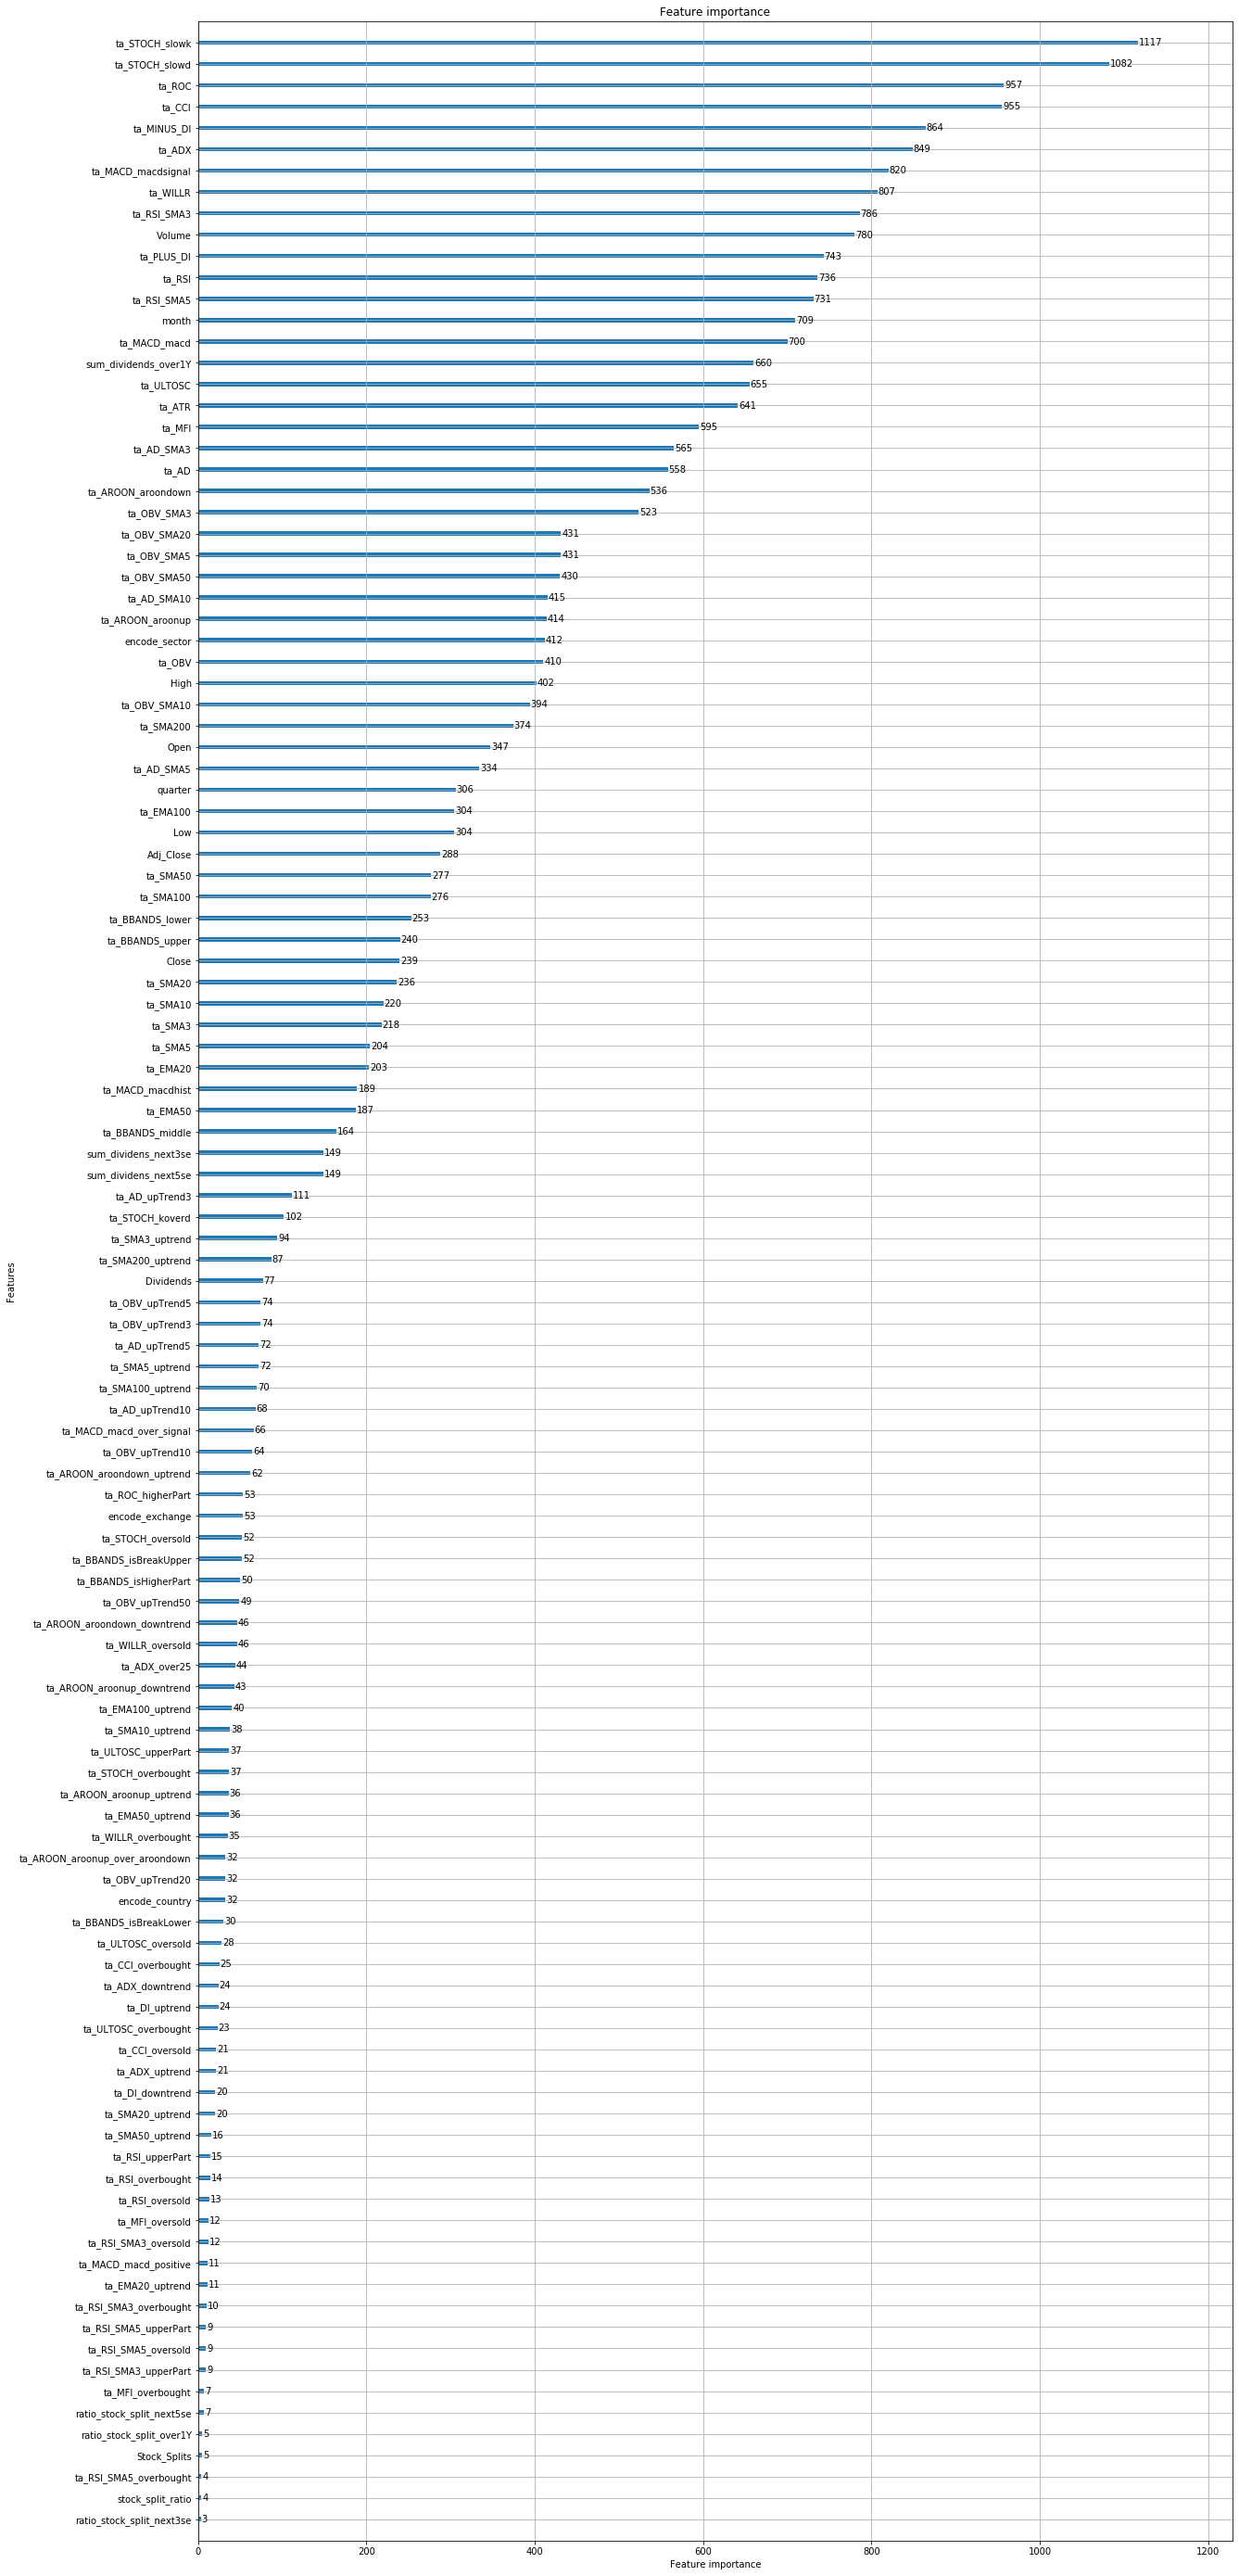

In [65]:
fig, ax = plt.subplots(figsize=(20, 50))
lgb.plot_importance(model, ax=ax)

In [47]:
%%time
corr = df.corr()

Wall time: 37.1 s


In [51]:
corr[['label']].sort_values(by='label')

,label
ta_WILLR,-0.024842
ta_OBV_upTrend3,-0.024606
ta_RSI,-0.024450
ta_PLUS_DI,-0.024004
ta_CCI,-0.023361
ta_SMA10_uptrend,-0.022802
ta_ULTOSC,-0.021711
ta_STOCH_slowk,-0.021470
ta_SMA3_uptrend,-0.021270
ta_SMA5_uptrend,-0.020870


In [63]:
s = pd.Series([1, 2, 3, 4, 5])
s

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [114]:
s.rolling(3).sum().shift(-3)

0     9.0
1    12.0
2     NaN
3     NaN
4     NaN
dtype: float64

In [67]:
s.rolling(3).apply(np.prod)

0     NaN
1     NaN
2     6.0
3    24.0
4    60.0
dtype: float64

In [47]:
help(talib.SMA)

Help on function SMA in module talib._ta_lib:

SMA(...)
    SMA(real[, timeperiod=?])
    
    Simple Moving Average (Overlap Studies)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 30
    Outputs:
        real



In [14]:
import matplotlib.pyplot as plt

In [47]:
close = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Adj Close']
high = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['High']
low = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Low']
# ta_SMA10 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA10']
# ta_SMA20 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA20']

# upper = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_upper']
# lower = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_lower']

# macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
ta_STOCH_slowk = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowk']
ta_STOCH_slowd = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowd']


slowk, slowd = talib.STOCH(high, low, close)

In [49]:
slowd - ta_STOCH_slowd

10100             NaN
10101             NaN
10102             NaN
10103             NaN
10104             NaN
10105             NaN
10106             NaN
10107             NaN
10108   -3.836931e-13
10109   -3.907985e-13
10110   -3.872458e-13
10111   -3.907985e-13
10112   -3.836931e-13
10113   -3.907985e-13
10114   -3.836931e-13
10115   -3.836931e-13
10116   -3.836931e-13
10117   -3.694822e-13
10118   -3.836931e-13
10119   -3.765876e-13
10120   -3.765876e-13
10121   -3.801404e-13
10122   -3.836931e-13
10123   -3.765876e-13
10124   -3.694822e-13
10125   -3.694822e-13
10126   -3.836931e-13
10127   -3.765876e-13
10128   -3.765876e-13
10129   -3.801404e-13
10130   -3.765876e-13
10131   -3.765876e-13
10132   -3.765876e-13
10133   -3.801404e-13
10134   -3.801404e-13
10135   -3.801404e-13
10136   -3.836931e-13
10137   -3.765876e-13
10138   -3.765876e-13
10139   -3.765876e-13
10140   -3.765876e-13
10141   -3.765876e-13
10142   -3.765876e-13
10143   -3.801404e-13
10144   -3.801404e-13
10145   -3

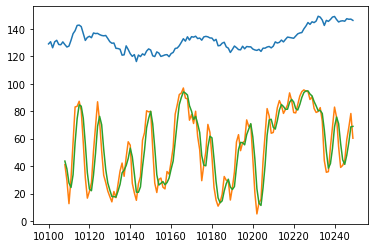

In [51]:
plt.plot(close, label='Closing Prices')
# plt.plot(rsi.values, label='rsi')
plt.plot(slowk, label='slowk')
plt.plot(slowd, label='slowd')
plt.show()

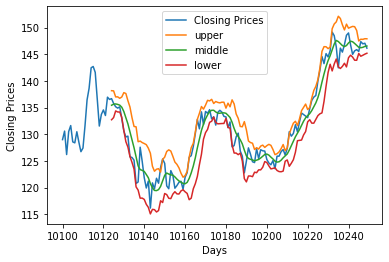

In [32]:
import matplotlib.pyplot as plt
# Plot the data
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(close, label='Closing Prices')
plt.plot(upper, label='upper')
plt.plot(middle, label='middle')
plt.plot(lower, label='lower')
plt.legend()
plt.show()

In [22]:
tmp = pd.DataFrame(np.random.random(100))

tmp['SMA'] = talib.SMA(tmp[0], timeperiod=10)

tmp

,0,SMA
0,0.110771,NaN
1,0.319976,NaN
2,0.020773,NaN
3,0.574633,NaN
4,0.239380,NaN
5,0.253053,NaN
6,0.870962,NaN
7,0.656281,NaN
8,0.599411,NaN
9,0.991397,0.463664
